In [1]:
import logging
import os
import pickle

import wandb
import datasets
import torch
import numpy as np
from dotenv import dotenv_values
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from transformers import pipeline, AutoImageProcessor, AutoModel
from transformers.image_processing_base import BatchFeature
from scipy.cluster.hierarchy import dendrogram

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

device = "cuda:0"

if 'notebooks' in os.getcwd():
    os.chdir("../")

In [2]:
local_config = dotenv_values(".env")

run = wandb.init(
    project=local_config["WANDB_PROJECT"],
    config={
        "job_type": "concept-generation",
    },
    save_code=False,
)

wandb: Currently logged in as: nhathcmus to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [12]:
%load_ext autoreload
%autoreload 2
from exrep.registry import load_data, save_tensor, load_entry, save_file, save_pickle
from exrep.utils import generic_map

crops_dataset = load_data(
    base_name="imagenet",
    phase="crops",
    load_local=True,
)

image_dataset = load_data(
    base_name="imagenet",
    phase="images",
    load_local=True,
)

INFO:exrep.registry:Loading data from local data dir data/imagenet-1k-first-20-take-2000_crops
INFO:exrep.registry:Loading data from local data dir data/imagenet-1k-first-20-take-2000_images


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# we either compute the clustering or load it from disk
load_clustering = True

if not load_clustering:
    processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
    model = AutoModel.from_pretrained("facebook/dinov2-base").to(device)
    dataloader = torch.utils.data.DataLoader(
        crops_dataset.with_transform(
            lambda x: processor(images=x['crops'], return_tensors="pt")
        ),
        batch_size=128,
    )
    embeddings = generic_map(
        model,
        dataloader,
        post_proc_fn=lambda x: x.pooler_output,
        input_format="keyword",
        device=device
    )
    logger.info("Embeddings shape: %s", embeddings.shape)

    clustering = AgglomerativeClustering(n_clusters=1, metric='euclidean', compute_distances=True).fit(embeddings.cpu().numpy())

    with open("outputs/clustering.pkl", "wb") as f:
        pickle.dump(clustering, f)
    
    save_file(
        base_name="imagenet",
        phase="clustering",
        type="scikit-clustering",
        file_path="outputs/clustering.pkl",
        file_name="agglomerative.pkl",
        wandb_run=run,
    )
else:
    clustering_pkl = load_entry(
        artifact_name="imagenet-1k-first-20-take-2000_clustering",
        file_name="agglomerative.pkl",
        wandb_run=run,
    )
    with open(clustering_pkl, "rb") as f:
        clustering = pickle.load(f)
    dendograms = {}

In [ ]:
from exrep.viz import plot_dendrogram, get_cluster_leaves, get_cluster_children

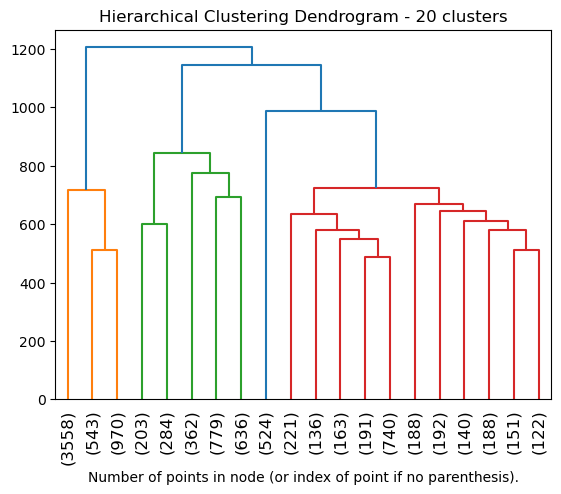

In [6]:
clusters_to_compute = [20, 40, 80, 160, 320]
clusters_to_viz = clusters_to_compute[0]

for n_clusters in clusters_to_compute:
    if n_clusters not in dendograms:
        dendograms[n_clusters] = plot_dendrogram(
            clustering, truncate_mode="lastp", p=n_clusters, leaf_rotation=90, 
            no_plot=n_clusters!=clusters_to_viz
        )

plt.title(f"Hierarchical Clustering Dendrogram - {clusters_to_viz} clusters")
# plot the top three levels of the dendrogram
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
# upper_to_lower = get_cluster_children(clustering, dendograms[20]['leaves'], dendograms[80]['leaves'])
# upper_to_lower

In [ ]:
# cluster_to_viz = 20462
# viz_labels, subtrees = get_cluster_leaves(upper_to_lower[cluster_to_viz], clustering)
# viz_clusters(upper_to_lower[cluster_to_viz], viz_labels)

In [ ]:
from typing import Sequence
from sklearn.preprocessing import LabelEncoder

indexed_crops_dataset = crops_dataset.map(
    lambda x: {"image_index": x.split("_")[0]},
    input_columns="index",
    keep_in_memory=True, 
    remove_columns=crops_dataset.column_names,
    num_proc=2, 
)

def compute_local_encoding(
    cluster_ids: Sequence[int], clustering, indexed_crops_dataset: datasets.Dataset,
    n_images: int,
    min_cluster_size=5,
):
    cluster_labels, _ = get_cluster_leaves(cluster_ids, clustering)
    # filter out clusters with less than min_cluster_size elements
    cluster_indices = {}
    for i in cluster_ids:
        crop_indices = np.where(cluster_labels == i)[0]
        image_indices = np.unique(indexed_crops_dataset[crop_indices]['image_index']).astype(int)
        if len(image_indices) >= min_cluster_size:
            cluster_indices[i] = image_indices

    label_encoder = LabelEncoder().fit(list(cluster_indices.keys()))
    local_encoding = np.zeros((n_images, label_encoder.classes_.shape[0]))
    normalized_ids = label_encoder.transform(list(cluster_indices.keys()))
    for i, indices in zip(normalized_ids, cluster_indices.values()):
        local_encoding[indices, i] = 1
    return local_encoding, label_encoder

artifact = None
for n_clusters in clusters_to_compute:
    local_encoding, label_encoder = compute_local_encoding(dendograms[n_clusters]['leaves'], clustering, indexed_crops_dataset, len(image_dataset))
    logger.info("Local encoding for %d clusters has shape %s and sum %s", n_clusters, local_encoding.shape, local_encoding.sum())
    artifact = save_tensor(
        torch.from_numpy(local_encoding),
        base_name="imagenet",
        phase="local-encoding",
        identifier=f"agglomerative",
        type="torch_tensor",
        metadata={
            "objective": "ward",
        },
        file_name=f"local-encoding_{n_clusters}.pt",
        wandb_run=run,
        artifact=artifact,
        force_create=True,
        finalize=False,
    )
    artifact = save_pickle(
        label_encoder,
        file_name=f"label-encoder-{n_clusters}.pkl",
        artifact=artifact,
        finalize=False,
    )
run.log_artifact(artifact)

Map (num_proc=2):   0%|          | 0/10291 [00:00<?, ? examples/s]

INFO:__main__:Local encoding for 20 clusters has shape (2000, 20) and sum 3968.0
INFO:exrep.registry:Creating artifact imagenet-1k-first-20-take-2000_local-encoding_agglomerative:latest on wandb
INFO:__main__:Local encoding for 40 clusters has shape (2000, 40) and sum 4953.0
INFO:__main__:Local encoding for 80 clusters has shape (2000, 78) and sum 5507.0
INFO:__main__:Local encoding for 160 clusters has shape (2000, 153) and sum 5907.0
INFO:__main__:Local encoding for 320 clusters has shape (2000, 277) and sum 6240.0


<Artifact imagenet-1k-first-20-take-2000_local-encoding_agglomerative>

In [14]:
wandb.finish()